# Dashboard zur Auswertung von Rezepten

Grundlage sind die Datenbank Spoonacular sowie der Subreddit "food"

### Use Cases:
##### Reddit:
1. Postzeit (Uhrzeit) der besten Posts
2. Postzeit (Uhrzeit) der schlechtesten Posts
3. längste Zeit in Top
4. kürzeste Zeit in Top(?)
5. Länge des Titels in Bezug auf Ups/Dauer in Top
6. Kategorisierung mit NLP bzgl. Süß/Herzhaftes Gericht
7. Kategorisierung mit Bilderkennung bzgl. Süß/Herzhaftes Gericht
8. Up’s abhängig von Autor
9. Anzahl der Kommentare in Abhängigkeit von Ups
10. Anzahl der Kommentare in Abhängigkeit von Postzeit
11. Anzahl der Kommentare in Abhängigkeit von Autor
12. Anzahl der Kommentare über die Zeit
13. Anzahl der Ups über die Zeit
14. Kommentare: 
    1. Beziehung zwischen Personen erkennen/clustern


    
##### Spoonacular:
15. Anteil vegane/vegetarische/fleischlastige Gerichte
16. Anteil laktosefreie Gerichte
17. Anteil glutenfreier Gerichte
18. Bewertung im Verhältnis zu Inhaltsstoffen
    1. Zucker    
    2. Fett
    3. Kalorien
19. Zubereitungszeit in Abhängigkeit von Likes
20. Kategorisierung aufgrund von Inhaltsstoffen
21. Zubereitungszeit in Abhängigkeit von Kategorie 


##### Kombi:
22. Kombi aus Spoonacular Nr. 17 und Top 10 der letzten 24h
23. Vergleich der Beliebtheit der Rezepte: Spoonacular Likes vs. Reddit Ups


## Requirements

In [1]:
# Final Variablen
API_KEY_SPOONACULAR = "146fe79a630b4afb8306a2985bedc64c"
API_KEY_SPOONACULAR = "6e0a91c81983423792b327bc4b78bb1d"

API_KEY_REDDIT = "KAJ2xGzCOlH3hyTRADNdSBDuTBORvw"
API_CLIENTID_REDDIT = "tSemvcUBRFCTYQ"

USERNAME_REDDIT = "Short-Arrival7632"
PW_REDDIT = "cookies123"

In [2]:
# KONFIGURATION

LIMIT_REDDIT_POSTS = 100
LIMIT_SPOONACULAR_RECIPES = 100
REDDIT_SAVE_INTERVALL = 10 # Minuten

In [3]:
# Auf Windows ausführen (einmalig)
# !pip install praw
# !pip install pandas
# !pip install matplotlib
# !pip install mysql-connector-python

In [4]:
# Auf Linux ausführen (einmalig)
"""
!pip3 install praw
!pip3 install pandas
!pip3 install matplotlib
!pip3 install mysql-connector-python
"""

'\n!pip3 install praw\n!pip3 install pandas\n!pip3 install matplotlib\n!pip3 install mysql-connector-python\n'

In [5]:
import praw
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

### Connect to Database

In [6]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [7]:
cursor = db_connection.cursor()

In [8]:
db_connection.commit()

In [9]:
cursor.execute("select count(id) from reddit")

In [10]:
for blub in cursor:
    print(blub[0])

819500


### Get Data from Subreddit DB

In [11]:
dfr = pd.read_sql("SELECT * FROM reddit order by ups desc", db_connection)

### 1. Postzeit der besten Posts (0.9 Quantil)

In [12]:
dfr_wds = dfr[["title", "ups", "time_created", "hour_created", "num_comments", "author"]]
# dfr_wds = dfr_wd.sort_values("ups", ascending=False)
dfr_wods = dfr_wds.drop_duplicates(subset=["title"]).copy()
dfr_wods["time"] = pd.to_datetime(dfr_wods["time_created"])
dfr_wodss = dfr_wods[(dfr_wods["ups"]>dfr_wods["ups"].quantile(0.9))].copy()
dfr_wodsl = dfr_wods[dfr_wods["ups"]<dfr_wods["ups"].quantile(0.1)].copy()
hour_dict = dfr_wodss.value_counts(subset=["hour_created"]).to_dict()
#hour_dict

In [13]:
dfr["day_created"] = pd.to_datetime(dfr["day_created"]).dt.date
dfr["time_created"] = pd.to_datetime(dfr["time_created"]).dt.time
dfr["curr_time"] = pd.to_datetime(dfr["curr_time"])

dtstuff = dfr.apply(
    lambda row: datetime.combine(row['day_created'], row['time_created']),
    axis=1
)
dfr["time"] = dtstuff

In [14]:
dfr["time"] = dfr["time"] - timedelta(hours=10) # weil Jakob verkackt hat, die Daten in UTC Zeit zu speichern :(
dfr["post_id"] = dfr.agg('{0[author]}-{0[time]}'.format, axis=1) # dauert lange, ist aber wichtig

In [15]:
dfr["duration"] = dfr["curr_time"] - dfr["time"]
dfr["duration_seconds"] = dfr["duration"].dt.total_seconds()
dfr["duration_seconds"]
dfr["duration_hours"] = dfr["duration_seconds"]/3600

### 2. Postzeit Beste (>0.9 Quantil) vs Schlechteste (<0.1 Quantil) Posts

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


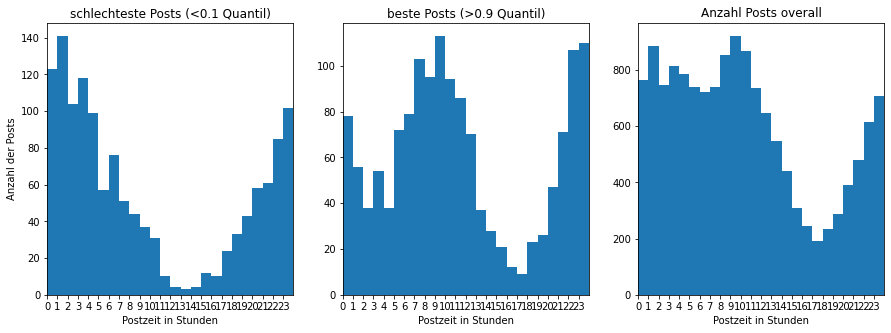

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(15,5))

ax1.set_title("schlechteste Posts (<0.1 Quantil)")
ax1.hist(pd.to_numeric(dfr_wodsl["hour_created"]), bins=range(25))
ax1.set_xlabel("Postzeit in Stunden")
ax1.set_xticks(range(24))
ax1.set_xlim([0,24])
ax1.set_ylabel("Anzahl der Posts")

ax2.set_title("beste Posts (>0.9 Quantil)")
ax2.hist(pd.to_numeric(dfr_wodss["hour_created"]), bins=range(25))
ax2.set_xlabel("Postzeit in Stunden")
ax2.set_xticks(range(24))
ax2.set_xlim([0,24])

ax3.set_title("Anzahl Posts overall")
ax3.hist(pd.to_numeric(dfr_wods["hour_created"]), bins=range(25))
ax3.set_xlabel("Postzeit in Stunden")
ax3.set_xticks(range(24))
ax3.set_xlim([0,24])

fig.show()

### 3. längste Zeit in Top

In [17]:
dfr_ds = dfr.sort_values(by=["duration"], ascending=False)
dfr_ds.head()

,id,hour_created,time_created,day_created,author,title,ups,downs,num_comments,text,thumbnail,url,curr_time,time,post_id,duration,duration_seconds,duration_hours
4272,707121,00,00:54:20,2021-03-31,sugardevotion,[homemade] macarons,23412,0,544,,https://a.thumbs.redditmedia.com/gRWfkgfCCB3i2...,https://i.redd.it/8477dn4si6q61.jpg,2021-04-01 11:50:07.180542,2021-03-30 14:54:20,sugardevotion-2021-03-30 14:54:20,1 days 20:55:47.180542,161747.180542,44.929772
4268,707019,00,00:54:20,2021-03-31,sugardevotion,[homemade] macarons,23417,0,544,,https://a.thumbs.redditmedia.com/gRWfkgfCCB3i2...,https://i.redd.it/8477dn4si6q61.jpg,2021-04-01 11:40:05.976695,2021-03-30 14:54:20,sugardevotion-2021-03-30 14:54:20,1 days 20:45:45.976695,161145.976695,44.762771
2275,692523,00,00:52:47,2021-03-30,everythingbagellover,[homemade] Honey BBQ Chicken Pot Pie,27670,0,508,,https://b.thumbs.redditmedia.com/DwuU8pyRL6RY5...,https://i.redd.it/m6lim61ldzp61.jpg,2021-03-31 11:30:06.060583,2021-03-29 14:52:47,everythingbagellover-2021-03-29 14:52:47,1 days 20:37:19.060583,160639.060583,44.621961
4269,706913,00,00:54:20,2021-03-31,sugardevotion,[homemade] macarons,23415,0,544,,https://a.thumbs.redditmedia.com/gRWfkgfCCB3i2...,https://i.redd.it/8477dn4si6q61.jpg,2021-04-01 11:30:05.581001,2021-03-30 14:54:20,sugardevotion-2021-03-30 14:54:20,1 days 20:35:45.581001,160545.581001,44.595995
16954,823309,07,07:40:05,2021-04-08,thebreadittor,[Homemade] Pastrami sandwich and hazy IPA,12059,0,260,,https://a.thumbs.redditmedia.com/1NFOaayf8rJ-L...,https://i.redd.it/kks7kjzfmtr61.jpg,2021-04-09 18:10:06.040009,2021-04-07 21:40:05,thebreadittor-2021-04-07 21:40:05,1 days 20:30:01.040009,160201.040009,44.500289


In [18]:
dfr_ds.drop_duplicates(subset=["post_id"], inplace=True)

### Kennzahl: Durchschnittliche Zeit in TOP

In [19]:
v = []
v.append(["all",(dfr_ds["duration"].mean().total_seconds())/3600])
v.append([">0.9 Quantil",(dfr_ds[dfr_ds["ups"]>dfr_ds["ups"].quantile(0.9)]["duration"].mean().total_seconds())/3600])
v.append(["<0.9 Quantil",(dfr_ds[dfr_ds["ups"]<dfr_ds["ups"].quantile(0.9)]["duration"].mean().total_seconds())/3600])
v.append(["<0.1 Quantil",(dfr_ds[dfr_ds["ups"]<dfr_ds["ups"].quantile(0.1)]["duration"].mean().total_seconds())/3600])
for val in v:
    print(val)

['all', 11.468868029166666]
['>0.9 Quantil', 26.382588461388888]
['<0.9 Quantil', 9.812507961111113]
['<0.1 Quantil', 3.747693090555556]


In [20]:
v=[]
for i in range(1,25):
    v.append((dfr_ds[dfr_ds["time"].dt.hour==i]["duration"].mean().total_seconds())/3600)

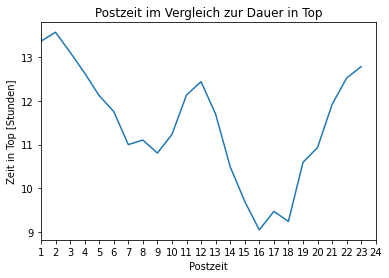

In [21]:
plt.plot([x for x in range(1,25)], v)

# plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xticks([x for x in range(1,25)])
plt.xlim([1,24])
plt.xlabel("Postzeit")
plt.ylabel("Zeit in Top [Stunden]")
plt.show()

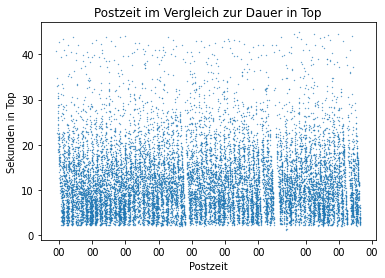

In [22]:
myFmt = pdt.DateFormatter("%H")

plt.scatter(dfr_ds["time"], (dfr_ds["duration_seconds"]/3600), s=0.1)

plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xlabel("Postzeit")
plt.ylabel("Sekunden in Top")
plt.show()

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


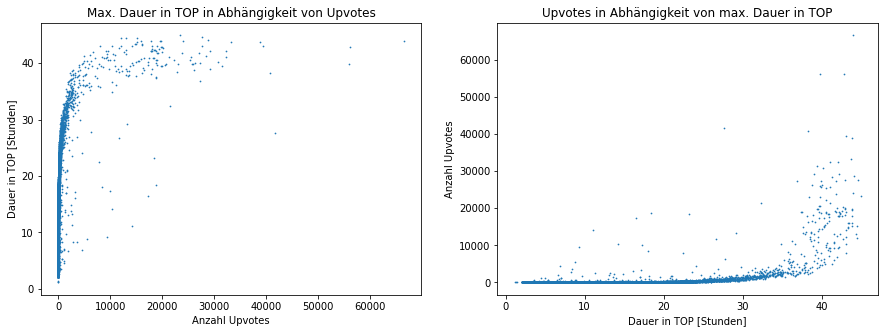

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.scatter(dfr_ds["ups"], (dfr_ds["duration_seconds"]/3600),  s=0.5)
ax1.set_title("Max. Dauer in TOP in Abhängigkeit von Upvotes")
ax1.set_xlabel("Anzahl Upvotes")
ax1.set_ylabel("Dauer in TOP [Stunden]")

ax2.scatter((dfr_ds["duration_seconds"]/3600),dfr_ds["ups"],  s=0.5)
ax2.set_title("Upvotes in Abhängigkeit von max. Dauer in TOP")
ax2.set_ylabel("Anzahl Upvotes")
ax2.set_xlabel("Dauer in TOP [Stunden]")

fig.show()

In [24]:
dfr_ds["hour_created"] = pd.to_numeric(dfr_ds["hour_created"])
dfr_ds[["ups", "duration_seconds", "hour_created"]].corr()

,ups,duration_seconds,hour_created
ups,1.000000,0.430000,0.051578
duration_seconds,0.430000,1.000000,0.106988
hour_created,0.051578,0.106988,1.000000


# Verlauf der Upvotes über die Zeit

In [25]:
dfru = pd.read_sql("SELECT * FROM users", db_connection)
dfru.set_index("username", inplace=True)

In [26]:
dfru.head()

,uid,created_utc,is_mod,is_employee,link_karma
username,,,,,
--NiNjA--,8148,1445357587.0,0,0,18028
-AA1,8149,1539884506.0,0,0,446
-aegeus-,8150,1425033981.0,0,0,67
-aube-,8151,1566319228.0,0,0,3574
-E-Cross,8152,1467608590.0,1,0,39666


In [27]:
new_df = dfr.join(dfru, on="author")

In [28]:
x = new_df[["title", "duration_hours", "ups", "post_id"]].groupby('post_id')
y_high = x.filter(lambda x: x["ups"].max() > dfr_wods["ups"].quantile(0.9))
y_low = x.filter(lambda x: x["ups"].max() < dfr_wods["ups"].quantile(0.1))
y_med = x.filter(lambda x: x["ups"].max() < dfr_wods["ups"].quantile(0.9))
z = y_high.groupby("post_id")

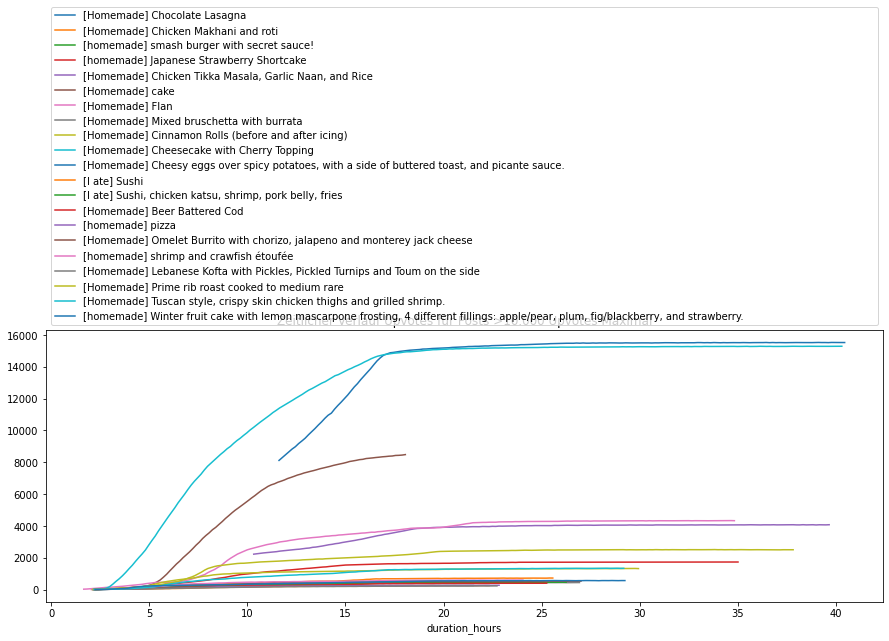

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
zähler = 0
for i, k in enumerate(z):
    label, df = k
    df.sort_values(by="duration_hours", inplace=True)
    df.plot(x="duration_hours", y="ups", kind="line", ax=ax, label=df["title"].iloc[0])
    if zähler == 20:
        break
    else:
        zähler +=1
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand")
plt.title("Zeitlicher Verlauf Upvotes für Posts >10.000 Upvotes Maximal")
plt.show()


duration_hours = 0 => Eintritt in TOP. Liegt daran, dass die Erstellungszeit nicht die Zeit sein muss, zu der es in TOP erscheint.

FRAGEN:
- wie können werte gesammelt werden von vor Eintritt in TOP? => post.created != post.created_utc -.-
- wie legende hinzufügen? => mit df["title"].iloc[0]
- wieso "flackert" die Linie... => ID war nicht eindeutig/wurde falsch formatiert

# Verlauf der Upvotes im Durchschnitt

In [30]:
hour_mean = []
h_mean_y_low = []
h_mean_y_med = []
h_mean_y_high = []
h_mean_all = []
h = []

for i in range(1,40):
    hour_mean.append([i, dfr[(dfr["duration_hours"]>i) & (dfr["duration_hours"]<i+1)]["ups"].mean()])
    h_mean_y_high.append(y_high[(y_high["duration_hours"]>i) & (y_high["duration_hours"]<i+1)]["ups"].mean())
    h_mean_y_med.append(y_med[(y_med["duration_hours"]>i) & (y_med["duration_hours"]<i+1)]["ups"].mean())
    h_mean_y_low.append(y_low[(y_low["duration_hours"]>i) & (y_low["duration_hours"]<i+1)]["ups"].mean())
    
    h_mean_all.append(dfr[(dfr["duration_hours"]>i) & (dfr["duration_hours"]<i+1)]["ups"].mean())
    h.append(i)

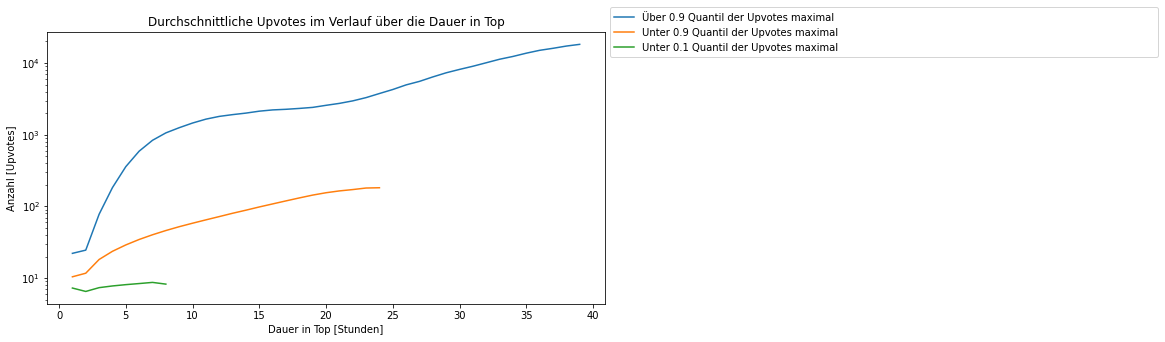

In [31]:
plt.figure(figsize=(10,5))
plt.title("Durchschnittliche Upvotes im Verlauf über die Dauer in Top")
plt.xlabel("Dauer in Top [Stunden]")
plt.ylabel("Anzahl [Upvotes]")
plt.yscale("log")

plt.plot(h, h_mean_y_high, label="Über 0.9 Quantil der Upvotes maximal")
plt.plot(h, h_mean_y_med, label="Unter 0.9 Quantil der Upvotes maximal")
plt.plot(h, h_mean_y_low, label="Unter 0.1 Quantil der Upvotes maximal")

# plt.plot(h, h_mean_all, label="Alle Posts")
plt.legend(bbox_to_anchor=(1, 1, 1, 0), loc="right", mode="expand")
plt.show()

### 5.1 Länge des Titels in Bezug auf Ups

In [32]:
dfr_wods["title_length"] = dfr_wods["title"].apply(len)
dfr_ds["title_length"] = dfr_ds["title"].apply(len)

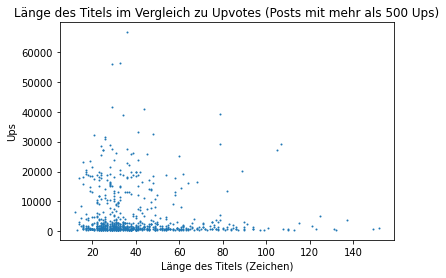

In [33]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["title_length"], 
           dfr_wods[dfr_wods["ups"]>limit]["ups"], s=1)
plt.title("Länge des Titels im Vergleich zu Upvotes (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Ups")
plt.show()

### 5.2. Länge des Titels in Bezug auf Dauer in Top

In [115]:
dfr_wods["title_length"] = dfr_wods["title"].apply(len)

In [ ]:
# limit = 500
# plt.scatter(dfrd_s[dfrd_s["max_ups"]>limit]["title_length"], 
#            dfrd_s[dfrd_s["max_ups"]>limit]["duration_minutes"])
# plt.title("Länge des Titels im Vergleich zu Dauer in Top (Posts mit mehr als " + str(limit) + " Ups)")
# plt.xlabel("Länge des Titels (Zeichen)")
# plt.ylabel("Dauer in Top")
# plt.show()

In [ ]:
# dfr_ds[["title_length", "ups", "duration_seconds"]].corr()

### 8. Ups abhängig vom Autor

In [35]:
author_dict = dfr_wods.value_counts(subset=["author"]).to_dict()

In [36]:
authors = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].sum()]
    authors.append(author)

In [37]:
dfa = pd.DataFrame(authors, columns=["author", "posts", "ups"])
dfa_s = dfa.sort_values("ups", ascending=False)
dfa_s.head()
dfa_ss = dfa_s[dfa_s["ups"]> 10000]

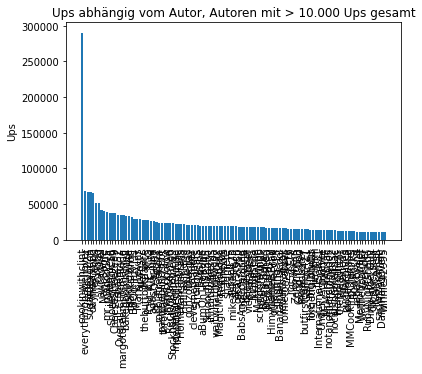

In [38]:
plt.bar(dfa_ss["author"], dfa_ss["ups"])
plt.xticks(rotation='vertical')
plt.title("Ups abhängig vom Autor, Autoren mit > 10.000 Ups gesamt")
plt.ylabel("Ups")
plt.show()

### 8.1. Anzahl Posts pro Autor in Abhängigkeit der Ups gesamt

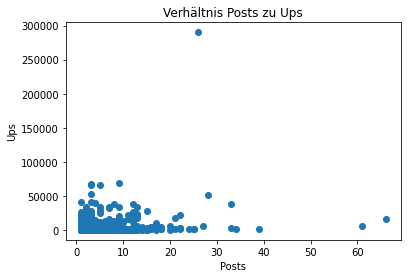

In [39]:
plt.scatter(dfa_s["posts"], dfa_s["ups"])
plt.xlabel("Posts")
plt.ylabel("Ups")
plt.title("Verhältnis Posts zu Ups")
plt.show()

### 9. Anzahl Kommentare in Abhängigkeit von Ups

In [40]:
m = int(dfr_ds["ups"].max())
print(m)
x = []
y = []
for i in range(0,m, 1000):
    x.append(i)
    y.append(dfr_ds[(dfr_ds["ups"]<=i)&(dfr_ds["ups"]>i-1000)]["num_comments"].mean())

66550


/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


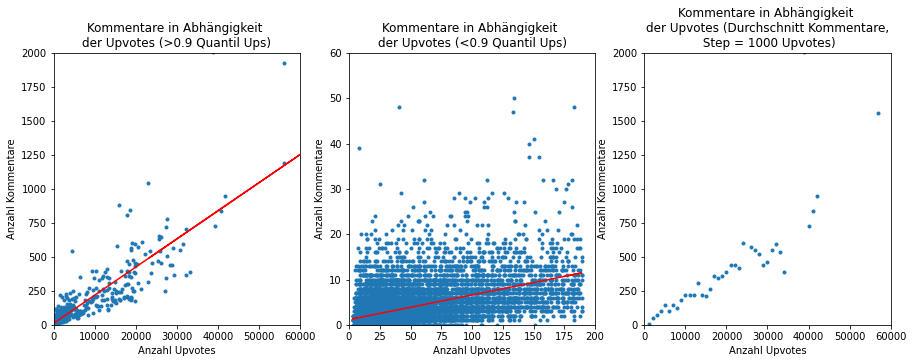

In [41]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
dfr_ups_comments_top = dfr_ds[dfr_ds["ups"]>dfr_ds["ups"].quantile(0.9)]
dfr_ups_comments_med = dfr_ds[dfr_ds["ups"]<dfr_ds["ups"].quantile(0.9)]

# Regressionsgrade

coef1 = np.polyfit(dfr_ups_comments_top["ups"],dfr_ups_comments_top["num_comments"],1)
poly1d_fn1 = np.poly1d(coef1) 

coef2 = np.polyfit(dfr_ups_comments_med["ups"],dfr_ups_comments_med["num_comments"],1)
poly1d_fn2 = np.poly1d(coef2) 


# Achsen
ax1.plot(dfr_ups_comments_top["ups"], dfr_ups_comments_top["num_comments"], 'o', dfr_ups_comments_top["ups"], poly1d_fn1(dfr_ups_comments_top["ups"]), '-r',markersize=3)
ax1.set_xlim([0,60000])
ax1.set_ylim([0,2000])
ax1.set_xlabel("Anzahl Upvotes")
ax1.set_ylabel("Anzahl Kommentare")
ax1.set_title("Kommentare in Abhängigkeit \nder Upvotes (>0.9 Quantil Ups)")

ax2.plot(dfr_ups_comments_med["ups"],dfr_ups_comments_med["num_comments"], 'o', dfr_ups_comments_med["ups"], poly1d_fn2(dfr_ups_comments_med["ups"]), '-r',markersize=3)
ax2.set_xlim([0,200])
ax2.set_ylim([0,60])
ax2.set_xlabel("Anzahl Upvotes")
ax2.set_ylabel("Anzahl Kommentare")
ax2.set_title("Kommentare in Abhängigkeit \nder Upvotes (<0.9 Quantil Ups)")

ax3.plot(x,y,'o',markersize=3)
ax3.set_xlim([0,60000])
ax3.set_ylim([0,2000])
ax3.set_xlabel("Anzahl Upvotes")
ax3.set_ylabel("Anzahl Kommentare")
ax3.set_title("Kommentare in Abhängigkeit \nder Upvotes (Durchschnitt Kommentare,\n Step = 1000 Upvotes)")

fig.show()

In [42]:
dfr_ds[["ups", "num_comments"]].corr()

,ups,num_comments
ups,1.000000,0.906397
num_comments,0.906397,1.000000


### 10. Anzahl Kommentare in Abhängigkeit von Postzeit

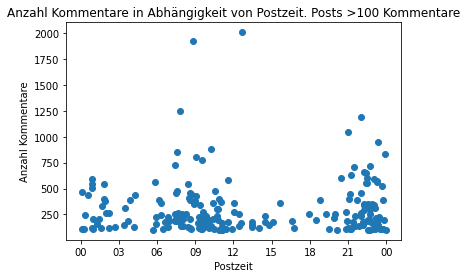

In [43]:
limit = 100
plt.scatter(dfr_wods[dfr_wods["num_comments"]>limit]["time"],
           dfr_wods[dfr_wods["num_comments"]>limit]["num_comments"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Anzahl Kommentare in Abhängigkeit von Postzeit. Posts >" + str(limit) + " Kommentare")
plt.xlabel("Postzeit")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 11. Anzahl Kommentare in Abhängigkeit vom Autor

In [111]:
df_counts = pd.DataFrame(dfr_ds[["author", "num_comments", "title"]].value_counts(subset=["author"]), columns=["num_posts"])
df_counts.reset_index(inplace=True)

In [112]:
dfar = pd.merge(dfr_ds, df_counts, on="author")
dfar_f = dfar[(dfar["num_posts"]>2)]
dfar_fg = dfar_f[["author", "title", "ups", "num_posts"]].groupby("author")

In [113]:
df_mean_user = dfar_f[["author", "title", "ups"]].groupby("author").mean()
df_std_user = dfar_f[["author", "title", "ups"]].groupby("author").std()

df_mean_user.rename({"ups":"mean_ups"}, axis=1, inplace=True)
df_std_user.rename({"ups":"std_ups"}, axis=1, inplace=True)

dfar = pd.merge(dfr_ds, df_mean_user, on="author")
dfar = pd.merge(dfar, df_std_user, on="author")

test = dfar_fg.filter(lambda x: (x["ups"].mean() > dfar.drop_duplicates(subset=["author"])["mean_ups"].quantile(0.9)))
dfar_fg = test.groupby("author")
test = dfar_fg.filter(lambda x: (x["ups"].std() < dfar.drop_duplicates(subset=["author"])["std_ups"].quantile(0.9)))

In [114]:
test

,author,title,ups,num_posts
1300,ShirtGeek,[Homemade] Cheeseburger,1657,6
1301,ShirtGeek,[Homemade] Cheeseburger,168,6
1302,ShirtGeek,[Homemade] Cheeseburger,1034,6
1303,ShirtGeek,[Homemade] Eggs Benedict,32,6
1304,ShirtGeek,[Homemade] Quesabirria Burger,23,6
1305,ShirtGeek,[Homemade] Cauliflower Steaks with saffron aioli,16,6
1356,Thechefanderson,[pro/chef] Coconut Tres Leches,1737,5
1357,Thechefanderson,[homemade] Whipped potato purée / Braised beef...,797,5
1358,Thechefanderson,[homemade] Surf & Turf,21,5
1359,Thechefanderson,[homemade]Herb crusted Lamb chop w/ Pesto pasta,16,5


In [82]:
authors2 = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].max(),
             dfr_wods[dfr_wods["author"]==key[0]]["num_comments"].max()]
    authors2.append(author)

In [83]:
authors2[0]

['MaxRamsey', 64, 2737, 53]

In [84]:
dfa2 = pd.DataFrame(authors2, columns=["author", "posts", "ups", "num_comments"])
dfa2_s = dfa2.sort_values("num_comments", ascending=False)

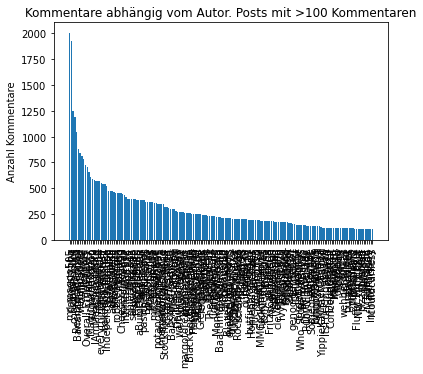

In [85]:
limit = 100
plt.bar(dfa2_s[dfa2_s["num_comments"]>limit]["author"], 
        dfa2_s[dfa2_s["num_comments"]>limit]["num_comments"])
plt.xticks(rotation='vertical')
plt.title("Kommentare abhängig vom Autor. Posts mit >" + str(limit) + " Kommentaren")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 12. Anzahl Kommentare über die Zeit

### 13. Performance nach Specifier/Kategorie?? [Homemade, I ate, Pro/Chef]

# Lessons Learned

- Dokumentation richtig lesen!
- created time muss nicht gleich created time in utc sein (das kann Auswertungen sehr spaßig machen)
- Reposts sind doof für Analysen (wenn man nicht dran denkt)